# DDPM (Denoising Diffusion Probabilistic Models) の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/3-2-1_ddpm.ipynb)

参考: https://github.com/JeongJiHeon/ScoreDiffusionModel/blob/main/DDPM/DDPM_MNIST.ipynb

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import pathlib

current_dir = pathlib.Path.cwd()
project_dir = current_dir / "data" / "ddpm"
project_dir.mkdir(exist_ok=True, parents=True)
print(f"Created a directory: {project_dir}")

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/ddpm


In [3]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

## 設定の定義

In [4]:
from py_img_gen.trainers import TrainDDPMConfig

train_config = TrainDDPMConfig(output_dir=project_dir)
print(train_config)

TrainDDPMConfig(output_dir=PosixPath('/root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/ddpm'), seed=42, batch_size=256, num_epochs=10, num_timesteps=500, lr=0.0001, num_workers=4, beta_1=0.0001, beta_T=0.02, eta_ddim=0.0)


In [5]:
from py_img_gen.trainers import EvalConfig

eval_config = EvalConfig()
print(eval_config)

EvalConfig(eval_epoch=1, num_generate_images=16, num_grid_rows=4, num_grid_cols=4)


In [6]:
from py_img_gen.trainers import DDPMModelConfig

model_config = DDPMModelConfig()
print(model_config)

DDPMModelConfig(sample_size=32, in_channels=1, out_channels=1, block_out_channels=(64, 128, 256, 512), layers_per_block=3, down_block_types=('DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'DownBlock2D'), up_block_types=('UpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D'))


## シードの固定

In [7]:
from transformers import set_seed

set_seed(seed=train_config.seed)

## Denoiser の定義

In [8]:
from dataclasses import asdict

from diffusers import UNet2DModel

unet = UNet2DModel(
    **asdict(model_config),
)
unet = unet.to(device)

## Noise Scheduler の定義

In [9]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=train_config.num_timesteps,
    beta_start=train_config.beta_1,
    beta_end=train_config.beta_T,
)

## Optimizer の定義

In [10]:
optim = torch.optim.Adam(
    unet.parameters(), lr=train_config.lr
)

## データセットの読み込み

In [11]:
from py_img_gen.trainers import (
    get_simple_resize_transforms,
)

transform = get_simple_resize_transforms(
    sample_size=model_config.sample_size
)
print(transform)

Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [12]:
import torchvision
from torch.utils.data import DataLoader

dataset = torchvision.datasets.MNIST(
    root=project_dir,
    train=True,
    download=True,
    transform=transform,
)

data_loader = DataLoader(
    dataset=dataset,
    batch_size=train_config.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=train_config.num_workers,
)

## DDPM の訓練

### 1 イテレーションの訓練プロセスを定義

In [13]:
import torch.nn.functional as F
from diffusers.utils import make_image_grid
from tqdm.auto import tqdm


def train_iteration(
    train_config: TrainDDPMConfig,
    unet: UNet2DModel,
    noise_scheduler: DDPMScheduler,
    optim: torch.optim.Optimizer,
    data_loader: DataLoader,
    device: torch.device,
) -> None:
    with tqdm(
        total=len(data_loader),
        desc="Iteration",
        leave=False,
    ) as pbar:
        for x, _ in data_loader:
            bsz = x.shape[0]
            x = x.to(device)

            t = torch.randint(
                low=0,
                high=train_config.num_timesteps,
                size=(bsz,),
                device=device,
            )

            z = torch.randn_like(x)
            x_noisy = noise_scheduler.add_noise(x, z, t)

            optim.zero_grad()

            z_pred = unet(x_noisy, t).sample
            loss = F.mse_loss(z_pred, z)

            loss.backward()
            optim.step()

            pbar.set_postfix(loss=loss.detach().item())
            pbar.update()

### エポック全体の訓練プロセスを定義

In [14]:
import dataclasses


def train(
    train_config: TrainDDPMConfig,
    eval_config: EvalConfig,
    unet: UNet2DModel,
    noise_scheduler: DDPMScheduler,
    optim: torch.optim.Optimizer,
    data_loader: DataLoader,
    device: torch.device,
) -> None:
    # UNet を訓練モードに設定
    unet.train()  # type: ignore[attr-defined]

    for epoch in tqdm(
        range(train_config.num_epochs), desc="Epoch"
    ):
        train_iteration(
            train_config=train_config,
            unet=unet,
            noise_scheduler=noise_scheduler,
            optim=optim,
            data_loader=data_loader,
            device=device,
        )
        images = inference(
            unet=unet,
            noise_scheduler=noise_scheduler,
            train_config=dataclasses.replace(
                train_config,
                batch_size=eval_config.num_generate_images,
            ),
        )
        image = make_image_grid(
            images=images,  # type: ignore
            rows=eval_config.num_grid_rows,
            cols=eval_config.num_grid_cols,
        )
        image.save(project_dir / f"{epoch=}.png")
        image.save(project_dir / "validation.png")

In [15]:
from typing import List, Union

from diffusers.schedulers.scheduling_ddpm import (
    DDPMSchedulerOutput,
)
from diffusers.utils.torch_utils import randn_tensor
from PIL.Image import Image as PilImage
from py_img_gen.utils import decode_images


@torch.no_grad()
def inference(
    unet: UNet2DModel,
    noise_scheduler: DDPMScheduler,
    train_config: TrainDDPMConfig,
    only_final: bool = True,
) -> Union[List[PilImage], List[List[PilImage]]]:
    # UNet を評価モードに設定
    unet.eval()  # type: ignore[attr-defined]
    # ノイズスケジューラにタイムステップを設定
    noise_scheduler.set_timesteps(
        train_config.num_timesteps
    )
    # 再現性のために推論用の乱数生成器を設定
    generator = torch.manual_seed(train_config.seed)

    # ノイズの形状を設定してからランダムノイズを生成
    x_shape = (
        train_config.batch_size,
        unet.config.in_channels,
        unet.config.sample_size,
        unet.config.sample_size,
    )
    x = randn_tensor(
        x_shape, generator=generator, device=unet.device
    )

    # 逆拡散過程を実行
    images, timesteps = [], noise_scheduler.timesteps
    for t in tqdm(
        timesteps, desc="Generating...", leave=False
    ):
        # ノイズ `z` を予測し、`z_pred` として取得
        z_pred = unet(x, t).sample

        # 一つ前の状態を計算: x_{t} -> x_{t-1}
        output = noise_scheduler.step(
            model_output=z_pred,
            timestep=t,  # type: ignore
            sample=x,
            generator=generator,
        )
        x = (
            output.prev_sample
            if isinstance(output, DDPMSchedulerOutput)
            else output[0]
        )
        if not only_final:
            images.append(decode_images(x))

    return decode_images(x) if only_final else images

### 訓練の実行

In [16]:
train(
    train_config=train_config,
    eval_config=eval_config,
    unet=unet,
    noise_scheduler=noise_scheduler,
    optim=optim,
    data_loader=data_loader,
    device=device,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

## DDPM の推論

### 推論過程のアニメーションの表示

Generating...:   0%|          | 0/500 [00:00<?, ?it/s]

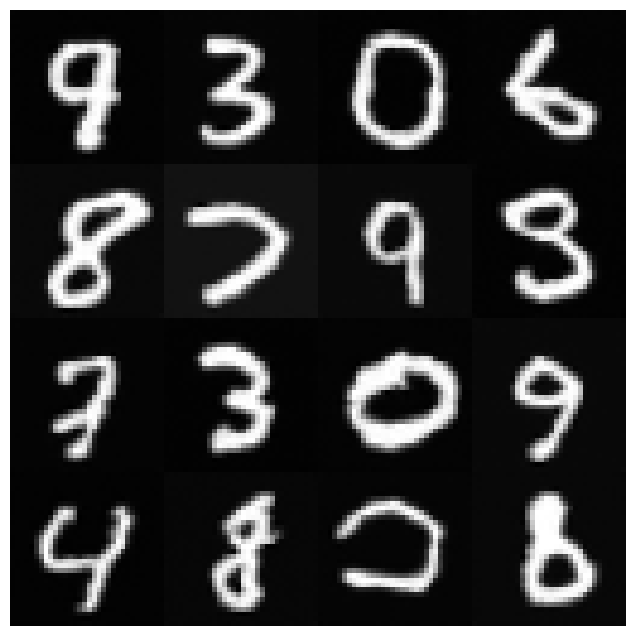

In [17]:
from IPython.display import HTML
from py_img_gen import inferencers

ani = inferencers.animation_inference(
    train_config=train_config,
    eval_config=eval_config,
    unet=unet,
    noise_scheduler=noise_scheduler,
)

HTML(ani.to_jshtml())

### diffusers のパイプラインによる推論

In [18]:
from diffusers import DDPMPipeline

pipe = DDPMPipeline(unet=unet, scheduler=noise_scheduler)
pipe = pipe.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

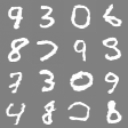

In [19]:
output = pipe(
    num_inference_steps=train_config.num_timesteps,
    batch_size=eval_config.num_generate_images,
    generator=torch.manual_seed(train_config.seed),
)
image = make_image_grid(
    images=output.images,
    rows=eval_config.num_grid_rows,
    cols=eval_config.num_grid_cols,
)
image